In [9]:
!git clone https://github.com/RainaVardhan/DS4002-Project-2.git

fatal: destination path 'DS4002-Project-2' already exists and is not an empty directory.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [11]:
#Loading the dataset from CSV file
df = pd.read_csv('/content/DS4002-Project-2/1950-2023_all_tornadoes.csv')
df.head(10)

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,len,wid,ns,sn,sg,f1,f2,f3,f4,fc
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,...,15.8,10,1,1,1,25,0,0,0,0
1,193,1950,10,9,1950-10-09,02:15:00,3,NC,37,9,...,2.0,880,1,1,1,47,0,0,0,0
2,195,1950,11,20,1950-11-20,02:20:00,3,KY,21,1,...,0.1,10,1,1,1,177,0,0,0,0
3,196,1950,11,20,1950-11-20,04:00:00,3,KY,21,2,...,0.1,10,1,1,1,209,0,0,0,0
4,197,1950,11,20,1950-11-20,07:30:00,3,MS,28,14,...,2.0,37,1,1,1,101,0,0,0,0
5,194,1950,11,4,1950-11-04,17:00:00,3,PA,42,5,...,15.9,100,1,1,1,71,11,0,0,0
6,198,1950,12,2,1950-12-02,15:00:00,3,IL,17,7,...,18.8,50,1,1,1,119,117,0,0,0
7,199,1950,12,2,1950-12-02,16:00:00,3,IL,17,8,...,18.0,200,1,1,1,119,5,0,0,0
8,200,1950,12,2,1950-12-02,16:25:00,3,AR,5,12,...,7.8,10,1,1,1,65,0,0,0,0
9,201,1950,12,2,1950-12-02,17:30:00,3,IL,17,9,...,9.6,50,1,1,1,157,0,0,0,0


In [12]:
#Convert date to datetime and filtered for Minnesota state
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
mn_df = df[df['st'] == 'MN']
mn_df['loss']

,loss
145,3.0
345,6.0
361,5.0
414,7.0
645,6.0
...,...
71167,0.0
71249,10000.0
71383,0.0
71385,0.0


In [27]:
# Create new column using dictionary
mapping = {1.0: 50, 2.0: 300, 3.0: 3000, 4.0: 30000, 5.0: 300000, 6.0: 3000000,
           7.0: 30000000, 8.0: 300000000, 9.0: 5000000000}

# combine this new data with existing DataFrame
mn_df['loss'] = mn_df['loss'].map(mapping).fillna(mn_df['loss'])
mn_df['loss'] = mn_df['loss'] != 0
mn_df

<ipython-input-27-52f31b63410b>:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mn_df['loss'] = mn_df['loss'].map(mapping).fillna(mn_df['loss'])
<ipython-input-27-52f31b63410b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mn_df['loss'] = mn_df['loss'].map(mapping).fillna(mn_df['loss'])
<ipython-input-27-52f31b63410b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,len,wid,ns,sn,sg,f1,f2,f3,f4,fc
145,141,1950,6,15,1950-06-15,16:42:00,3,MN,27,1,...,4.60,67,1,1,1,167,0,0,0,0
345,149,1951,6,19,1951-06-19,17:30:00,3,MN,27,1,...,52.60,330,1,1,1,85,171,53,3,0
361,165,1951,6,25,1951-06-25,15:00:00,3,MN,27,2,...,14.20,10,1,1,1,91,0,0,0,0
414,195,1951,7,20,1951-07-20,21:00:00,3,MN,27,3,...,11.60,10,1,1,1,53,0,0,0,0
645,171,1952,6,23,1952-06-23,16:30:00,3,MN,27,1,...,8.40,220,1,1,1,151,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71167,623128,2023,7,25,2023-07-25,22:01:00,3,MN,27,0,...,1.39,75,1,1,1,67,0,0,0,0
71249,623248,2023,8,13,2023-08-13,18:14:00,3,MN,27,0,...,1.25,50,1,1,1,105,0,0,0,0
71383,623318,2023,9,23,2023-09-23,14:56:00,3,MN,27,0,...,0.01,10,1,1,1,105,0,0,0,0
71385,623320,2023,9,23,2023-09-23,15:14:00,3,MN,27,0,...,0.25,25,1,1,1,73,0,0,0,0


In [28]:
#Group data by year and aggregate by property loss, crop loss, and tornado frequency
yearly_data = mn_df.groupby(mn_df['date'].dt.year).agg({
    'loss': 'sum',
    'om': 'count'
}).reset_index()

yearly_data.rename(columns={'om': 'num_tornadoes'}, inplace=True)
yearly_data

,date,loss,num_tornadoes
0,1950,1,1
1,1951,3,3
2,1952,7,7
3,1953,6,8
4,1954,7,7
...,...,...,...
69,2019,20,53
70,2020,29,60
71,2021,22,65
72,2022,20,71


In [29]:
#Checking for null values
yearly_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   date           74 non-null     int32
 1   loss           74 non-null     int64
 2   num_tornadoes  74 non-null     int64
dtypes: int32(1), int64(2)
memory usage: 1.6 KB


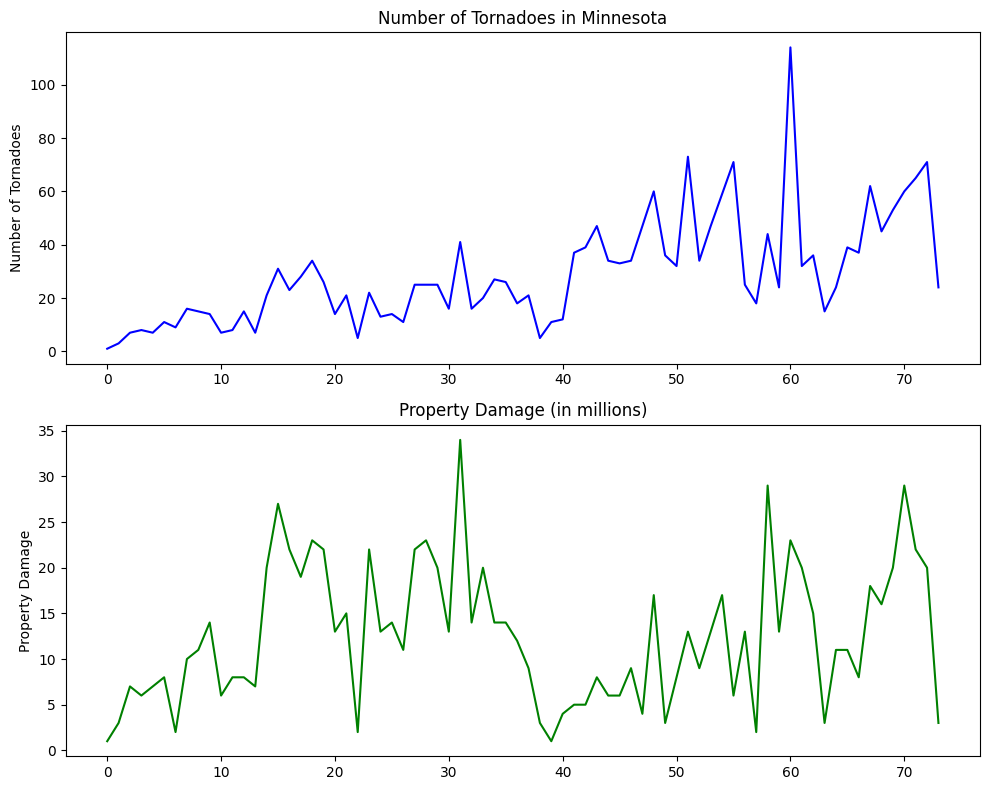

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

#Plot the number of tornadoes each year
yearly_data['num_tornadoes'].plot(ax=ax[0], title='Number of Tornadoes in Minnesota', color='blue')
ax[0].set_ylabel('Number of Tornadoes')

#Plot the property damage each year
yearly_data['loss'].plot(ax=ax[1], title='Property Damage (in millions)', color='green')
ax[1].set_ylabel('Property Damage')

plt.tight_layout()
plt.show()

In [31]:
#Perform ADF test to check for stationary of tornado data
result = adfuller(yearly_data['num_tornadoes'])
print(f"ADF Statistic for Number of Tornadoes: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic for Number of Tornadoes: -3.163187728851386
p-value: 0.022216872185095472


In [32]:
#Applying differencing if series is non-stationary (p-value > 0.05)
if result[1] > 0.05:
    yearly_data['num_tornadoes_diff'] = yearly_data['num_tornadoes'].diff().dropna()
    result = adfuller(yearly_data['num_tornadoes_diff'])
    stationarity_interpretation = "Stationary" if result[1] < 0.05 else "Non-Stationary"

else:
    yearly_data['num_tornadoes_diff'] = yearly_data['num_tornadoes']
    stationarity_interpretation = "Stationary"

print(f"ADF Statistic after differencing: {result[0]}")
print(f"p-value after differencing: {result[1]}")
print(f"Interpretation: The series is {stationarity_interpretation}.")

ADF Statistic after differencing: -3.163187728851386
p-value after differencing: 0.022216872185095472
Interpretation: The series is Stationary.


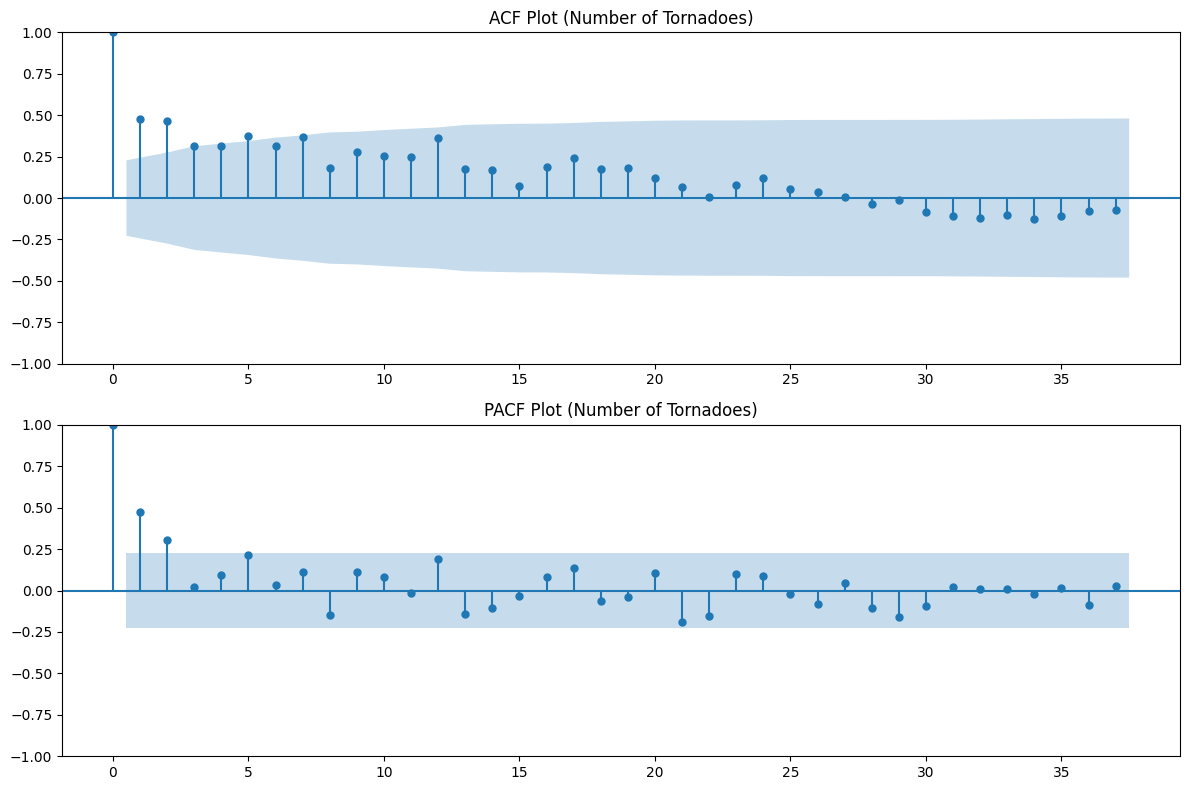

In [33]:
max_lags = min(40, len(yearly_data['num_tornadoes']) // 2)
fig, ax = plt.subplots(2, figsize=(12, 8))

#ACF plot to find 'q' (moving average term)
plot_acf(yearly_data['num_tornadoes'], lags=max_lags, ax=ax[0])
ax[0].set_title('ACF Plot (Number of Tornadoes)')

#PACF plot to find 'p' (autoregressive term)
plot_pacf(yearly_data['num_tornadoes'], lags=max_lags, ax=ax[1])
ax[1].set_title('PACF Plot (Number of Tornadoes)')

plt.tight_layout()
plt.show()

In [34]:
#Fit the ARIME model with parameters p, d, q
model = ARIMA(yearly_data['num_tornadoes_diff'].dropna(), order=(1, 1, 1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:     num_tornadoes_diff   No. Observations:                   74
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -307.800
Date:                Sun, 20 Oct 2024   AIC                            621.600
Time:                        20:33:09   BIC                            628.471
Sample:                             0   HQIC                           624.338
                                 - 74                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0302      0.137      0.220      0.826      -0.239       0.299
ma.L1         -0.8181      0.083     -9.851      0.000      -0.981      -0.655
sigma2       265.2081     26.142     10.145      0.0

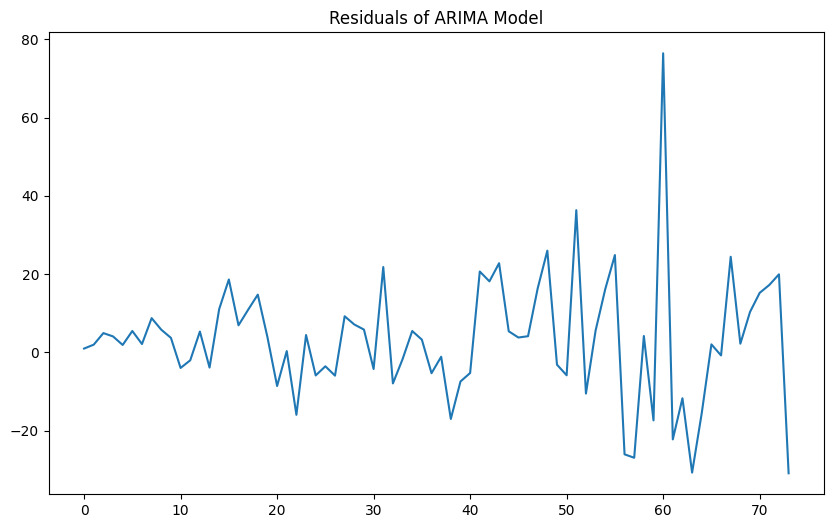

In [35]:
#Plot residuals of the fitted model to check if they resemble white noise
residuals = model_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals)
plt.title('Residuals of ARIMA Model')
plt.show()

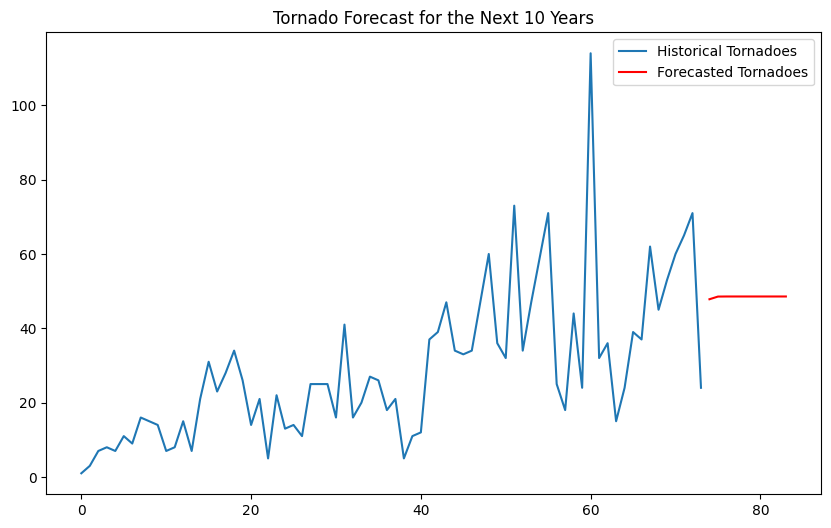

In [36]:
#Forecast for the next 10 years based on the fitted ARIMA model
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)
forecast_years = np.arange(yearly_data.index.max() + 1, yearly_data.index.max() + forecast_steps + 1)

#Plotting historical tornado data and forcasted tornadoes for the next 10 years
plt.figure(figsize=(10, 6))
plt.plot(yearly_data.index, yearly_data['num_tornadoes'], label='Historical Tornadoes')
plt.plot(forecast_years, forecast, label='Forecasted Tornadoes', color='red')
plt.title('Tornado Forecast for the Next 10 Years')
plt.legend()
plt.show()

In [37]:
#Evaluate the ARIMA model using AIC and BIC metrics
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

AIC: 621.5996808309274
BIC: 628.4710591543725


In [38]:
#Split data into training and testing sets for model validation
train_size = int(len(yearly_data) * 0.8)
train, test = yearly_data['num_tornadoes_diff'][:train_size], yearly_data['num_tornadoes_diff'][train_size:]

#Fit the ARIMA model on training data and forecast on the test data
p = 1
d = 1
q = 1
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

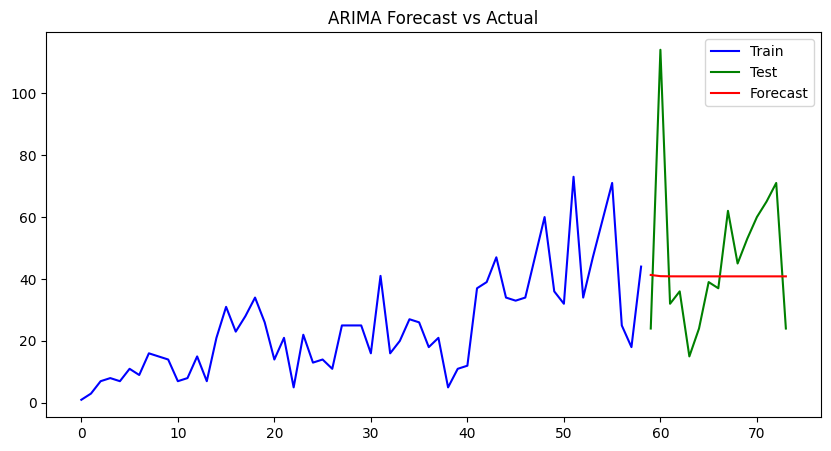

In [39]:
#Plot the training data, test data, and forecasted values
plt.figure(figsize=(10, 5))
plt.plot(yearly_data.index[:train_size], train, label='Train', color='blue')
plt.plot(yearly_data.index[train_size:], test, label='Test', color='green')
plt.plot(yearly_data.index[train_size:], forecast, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.show()

In [40]:
#Calculate RMSE to evaluate model's accuracy
rmse = mean_squared_error(test, forecast, squared=False)
print(f"RMSE: {rmse}")

RMSE: 25.125179439897508


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [42]:
#Applying differencing if series is non-stationary (p-value > 0.05)
if result[1] > 0.05:
    yearly_data['loss_diff'] = yearly_data['loss'].diff().dropna()
    result = adfuller(yearly_data['loss_diff'])
    stationarity_interpretation = "Stationary" if result[1] < 0.05 else "Non-Stationary"

else:
    yearly_data['loss_diff'] = yearly_data['loss']
    stationarity_interpretation = "Stationary"

print(f"ADF Statistic after differencing: {result[0]}")
print(f"p-value after differencing: {result[1]}")
print(f"Interpretation: The series is {stationarity_interpretation}.")

ADF Statistic after differencing: -3.163187728851386
p-value after differencing: 0.022216872185095472
Interpretation: The series is Stationary.


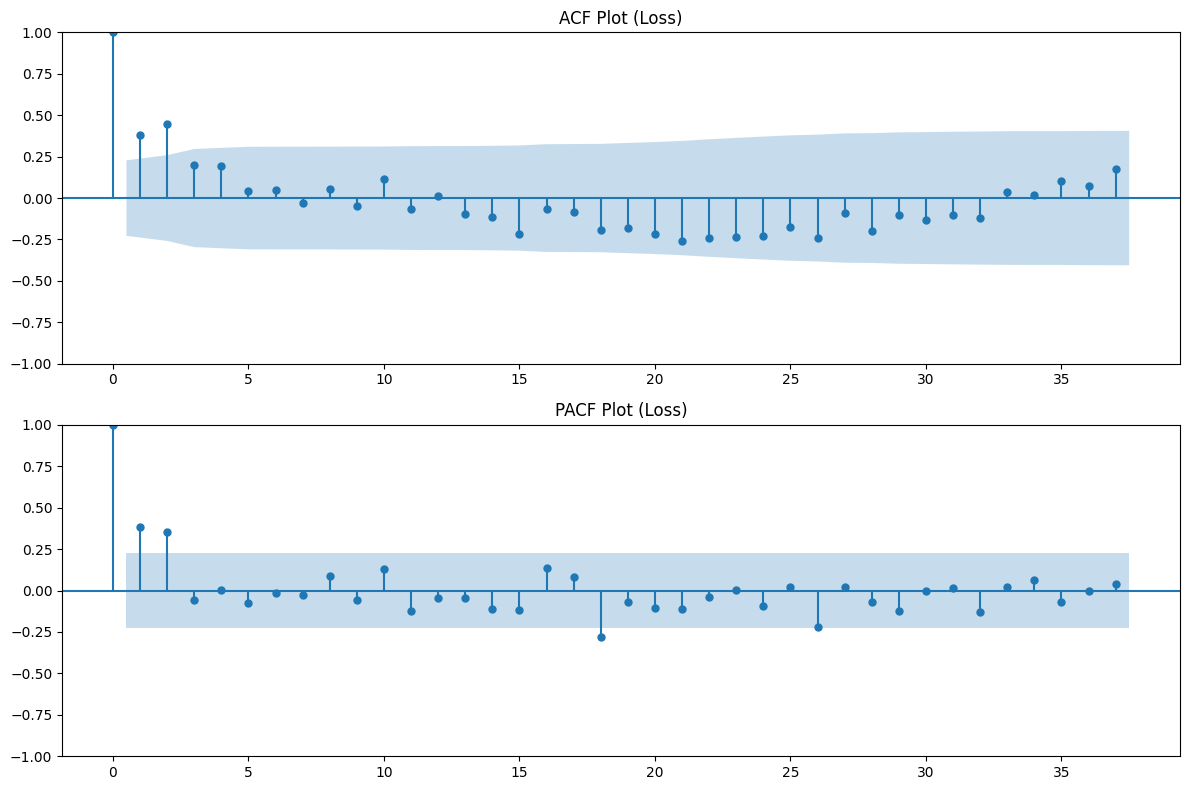

In [44]:
max_lags = min(40, len(yearly_data['loss']) // 2)
fig, ax = plt.subplots(2, figsize=(12, 8))

#ACF plot to find 'q' (moving average term)
plot_acf(yearly_data['loss'], lags=max_lags, ax=ax[0])
ax[0].set_title('ACF Plot (Loss)')

#PACF plot to find 'p' (autoregressive term)
plot_pacf(yearly_data['loss'], lags=max_lags, ax=ax[1])
ax[1].set_title('PACF Plot (Loss)')

plt.tight_layout()
plt.show()

In [47]:
#Fit the ARIME model with parameters p, d, q
model = ARIMA(yearly_data['loss'].dropna(), order=(1, 1, 1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                   loss   No. Observations:                   74
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -244.714
Date:                Sun, 20 Oct 2024   AIC                            495.428
Time:                        20:38:12   BIC                            502.300
Sample:                             0   HQIC                           498.167
                                 - 74                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4342      0.295     -1.472      0.141      -1.012       0.144
ma.L1         -0.1927      0.307     -0.628      0.530      -0.794       0.408
sigma2        47.5145      6.898      6.888      0.0

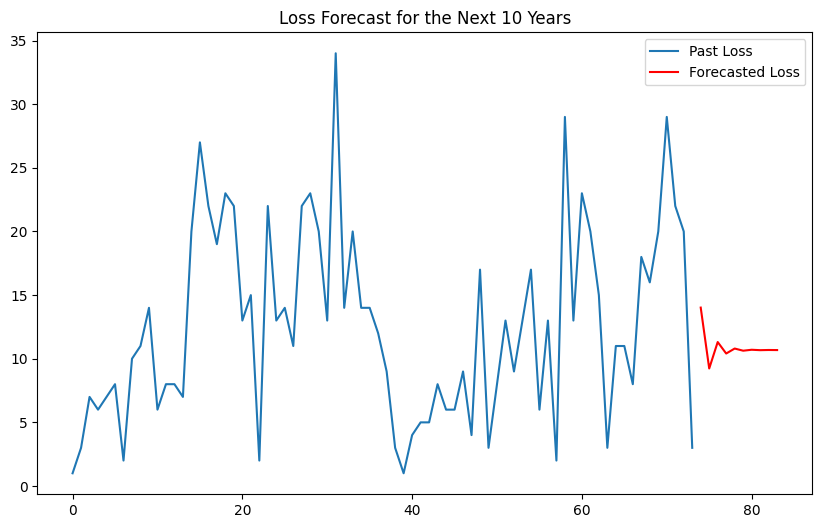

In [48]:
#Forecast for the next 10 years based on the fitted ARIMA model
forecast_steps = 10
forecast = model_fit.forecast(steps=forecast_steps)
forecast_years = np.arange(yearly_data.index.max() + 1, yearly_data.index.max() + forecast_steps + 1)

#Plotting historical tornado data and forcasted tornadoes for the next 10 years
plt.figure(figsize=(10, 6))
plt.plot(yearly_data.index, yearly_data['loss'], label='Past Loss')
plt.plot(forecast_years, forecast, label='Forecasted Loss', color='red')
plt.title('Loss Forecast for the Next 10 Years')
plt.legend()
plt.show()

In [49]:
#Evaluate the ARIMA model using AIC and BIC metrics
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

AIC: 495.4284060577403
BIC: 502.2997843811855


In [50]:
#Split data into training and testing sets for model validation
train_size = int(len(yearly_data) * 0.8)
train, test = yearly_data['loss'][:train_size], yearly_data['loss'][train_size:]

#Fit the ARIMA model on training data and forecast on the test data
p = 1
d = 1
q = 1
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()
forecast = model_fit.forecast(steps=len(test))

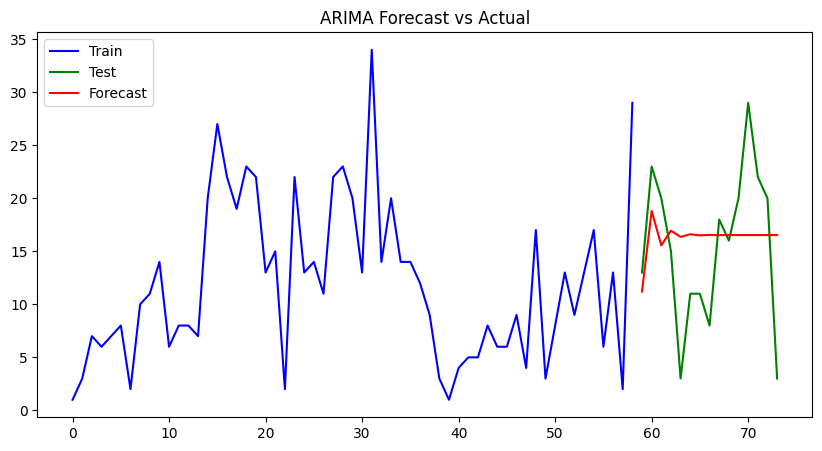

In [51]:
#Plot the training data, test data, and forecasted values
plt.figure(figsize=(10, 5))
plt.plot(yearly_data.index[:train_size], train, label='Train', color='blue')
plt.plot(yearly_data.index[train_size:], test, label='Test', color='green')
plt.plot(yearly_data.index[train_size:], forecast, label='Forecast', color='red')
plt.legend()
plt.title('ARIMA Forecast vs Actual')
plt.show()

In [52]:
#Calculate RMSE to evaluate model's accuracy
rmse = mean_squared_error(test, forecast, squared=False)
print(f"RMSE: {rmse}")

RMSE: 7.082056561426258


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
